In [1]:
import time
start_time=time.time()

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import interpolate
import strucfunc
import pickle
import json



In [3]:
reg = 'N604'
dist = 870000 #parsecs
pc = dist*(2*np.pi) / (360 * 60 * 60)
pc

4.217879025652963

In [4]:
pixscale = 0.26 # arcsec
pixscale *= pc            # parsec

In [5]:
pickle_in = open('VF2//' + reg + '.pkl',"rb")
data = pickle.load(pickle_in)
data

{'sb': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'vv': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]),
 'ss': array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]])}

In [6]:
sb = data['sb']
vv = data['vv']
ss = data['ss']

In [7]:
## Replace spurious values in the arrays
m = ~np.isfinite(sb*vv*ss) | (sb < 0.0)

sb[m] = 0.0
vv[m] = np.nanmean(vv)
ss[m] = 0.0
sb /= sb.max()

#good = (~m) & (sb > 0.001)

<ipython-input-7-7f70e0a3c852>:2: RuntimeWarning: invalid value encountered in less
  m = ~np.isfinite(sb*vv*ss) | (sb < 0.0)


In [8]:
rslt = strucfunc.strucfunc_numba_parallel(vv, wmap=sb, dlogr=0.15)

In [9]:
good = (~m) & (sb > 0.001)
rslt["Unweighted mean velocity"] = np.mean(vv[good])
rslt["Unweighted sigma^2"] = np.var(vv[good])
v0w = rslt["Weighted mean velocity"] = np.average(vv, weights=sb)
rslt["Weighted sigma^2"] = np.average((vv - v0w)**2, weights=sb)

In [10]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [11]:
jsonfilename = f"SFresults//"+ reg +".json"
with open(jsonfilename, "w") as f:
    json.dump(rslt, fp=f, indent=3, cls=MyEncoder)
print(jsonfilename, end="")

SFresults//N604.json

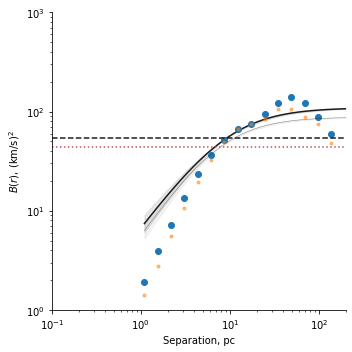

In [12]:
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def bfunc(r, r0, sig2, m):
    "Theoretical structure function"
    C = 1.0 / (1.0 + (r/r0)**m)
    return 2.0*sig2*(1 - C)

data = json.load(open("SFresults//"+ reg +".json"))

sns.set_color_codes()
fig, ax = plt.subplots(figsize=(5, 5))

#figfile = "tarantula-strucfunc-plot--f.pdf"


r = pixscale * 10**np.array(data["log10 r"])
B = np.array(data["Unweighted B(r)"])
sig2 = data["Unweighted sigma^2"]
B_w = np.array(data["Weighted B(r)"])
sig2_w = data["Weighted sigma^2"]

# Plot fit to unweighted strucfunc
rgrid = pixscale * np.logspace(0.0, 2.7)
r0 = np.interp(sig2, B, r)
m = 1.22
flabel = rf"$m = {m:.2f}$, $r_0 = {r0:.1f}$ pc, $\sigma^2 = {sig2:.0f}$ (km/s)$^2$"
ax.fill_between(
    rgrid,
    bfunc(rgrid, r0, sig2, m - 0.1),
    bfunc(rgrid, r0, sig2, m + 0.1),
    color="k", alpha=0.1,
)
ax.plot(rgrid, bfunc(rgrid, r0, sig2, m), color="k", label=flabel)

# Plot points from unweighted strucfunc
ax.plot(r, B, 'o', label="Unweighted")


# Plot fit to weighted strucfunc
r0_w = np.interp(sig2_w, B_w, r)
m_w = 1.30
flabel_w = rf"$m = {m_w:.2f}$, $r_0 = {r0_w:.1f}$ pc, $\sigma^2 = {sig2_w:.0f}$ (km/s)$^2$"
ax.fill_between(
    rgrid,
    bfunc(rgrid, r0_w, sig2_w, m_w - 0.1),
    bfunc(rgrid, r0_w, sig2_w, m_w + 0.1),
    color="k", alpha=0.05,
)
ax.plot(rgrid, bfunc(rgrid, r0_w, sig2_w, m_w), lw=0.5, color="k", alpha=0.5, label=flabel_w)

# Plot points from weighted strucfunc
ax.plot(r, B_w, 'o', ms=3, alpha=0.5, label="Flux-weighted")


#melnick_r = np.array([2.5, 7.5, 12.5, 17.5, 22.5, 27.5])
#melnick_B = np.array([2.0, 2.1, 2.2, 2.2, 2.25, 2.25]) * 18.2**2
#ax.plot(melnick_r, melnick_B, 's', label="Melnick+ (2020)", color="y", zorder=-10)


ax.axhline(sig2, color="k", ls="--")
ax.axhline(sig2_w, color="r", ls=":")
#ax.legend(title=r"30 Doradus H$\alpha$")
ax.set(
    xscale = "log",
    yscale = "log",
    ylim  = [1, 1000],
    xlim  = [0.1, 200],
    xlabel = "Separation, pc",
    ylabel = r"$B(r)$, (km/s)$^2$",
)
fig.tight_layout()
sns.despine()
#fig.savefig(figfile)
#fig.savefig(figfile.replace(".pdf", ".jpg"))

In [13]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 10.578214406967163 seconds ---
